Modified from the [original](https://github.com/willyhagi/climate-data-science) (Companion Jupyter Notebook to the [MODIS Vegetation Indices: a GEE Approach](https://towardsdatascience.com/modis-vegetation-indices-a-gee-approach-f48e1259e462) article, published in Towards Data Science) by [spestana](https://github.com/spestana/)

Furthur modified to aquire MODIS chlorophyll-a data product from Clear Lake Reservoir baisn by [meganeduffy](https://github.com/MeganEDuffy)

**Environment for this work:**

First I created the firewaterenv environment using Steven's .yml file:

`conda env create -name firewaterenv environment.yml`
    
Then initialized the environment using:

`conda activate firewaterenv`

**Import all the packages we'll be using here**

In [1]:
import ee 
import folium
import geehydro
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt 

from ipygee import *

**Initialize the Google Earth Engine library**

In [2]:
ee.Authenticate()

Enter verification code:  4/3wHUyogyeGE2N0Az_16xUU1E9iKwqK5iE2hwm7m9rI58b85wOyPgQVs



Successfully saved authorization token.


In [3]:
# Initialize the library.
ee.Initialize()

**Set our Area of Interest (AOI)**

[Clear Lake National Wildlife Refuge](https://www.fws.gov/refuge/clear_lake/) in California

Creating a GEE geometry from a shapefile, via geojson with geopandas ([info](https://gis.stackexchange.com/questions/333791/accessing-a-shapefile-with-googleearthengine-api-invalid-geojson-geometry))

In [4]:
clearlake_aoi = ee.Geometry.Rectangle([-121.0, 41.95,
                                   -121.3, 41.75])

In [5]:
# use geopandas to read our lake shapefile
clearlake = gpd.read_file("zip://../data/Clear_Lake_Res.zip")

# look at what we opened
clearlake

,DFGWATERID,TYPE,NAME,GNIS_NAME,GNIS_ID,COUNTY,QUAD_NAME,QUAD_CODE,LAT_NAD83,LON_NAD83,UTM_ZONE,UTM_N_N83,UTM_E_N83,MTR,elev_ft,sfc_acres,Shape_Leng,Shape_Area,geometry
0,8177,perennial,Clear Lake Reservoir,Clear Lake Reservoir,221199.0,Modoc,DOUBLE HEAD MTN.,41121G2,41.865752,-121.144879,10.0,4.636535e+06,653962.164441,M47N 07E,4484,25012.128035,110372.801128,1.012209e+08,"MULTIPOLYGON Z (((-89566.185 434787.792 0.000,..."


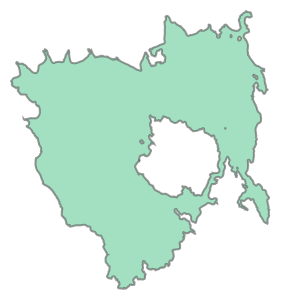

In [6]:
# preview it
clearlake_geom = clearlake.iloc[0].geometry
clearlake_geom

**Get MODIS Products**

[Full product list on GEE](https://developers.google.com/earth-engine/datasets/catalog/modis)

Here I want to get:
* MOD09Q1.006 Terra Surface Reflectance 8-Day Global 250m
* MOD17A2H.006: Terra Gross Primary Productivity 8-Day Global 500m

In [7]:
modis_ref = ee.ImageCollection('MODIS/006/MOD09Q1').filterDate(ee.DateRange('2016-01-01',
                                                                        '2019-12-01'))

modis_gpp = ee.ImageCollection("MODIS/006/MOD17A2H").filterDate(ee.DateRange('2016-01-01',
                                                                        '2019-12-01'))

**Get a surface water dataset:**

In [8]:
sw = ee.Image("JRC/GSW1_1/GlobalSurfaceWater")

In [9]:
# select the surface water occurence layer
sw_occurrence = sw.select('occurrence')

# set our threshold to where there's water 80% of the time
pctTime = 80

# get surface water where occurence is at 80% or greater
water = sw_occurrence.gte(pctTime)

In [10]:
# select sur_refl_b01 and sur_refl_b02
srb1 = modis_ref.select('sur_refl_b01')
srb2 = modis_ref.select('sur_refl_b02')

# select modis_gpp
gpp = modis_gpp.select('Gpp')

One issue with MODIS data is that you need to apply a scale factor according to the product you’re using to make sense of it. According to this User Guide (RTFM), the scale factor for both the MOD09Q1 and MOD17A2H products is 0.0001. That means we'll multiply each dataset by this scale factor to start using it properly.

In [11]:
def scale_factor_SR(image):
  # scale factor for the MODIS MOD09Q1 product
  return image.multiply(0.0001).copyProperties(image, ['system:time_start'])

def scale_factor_GPP(image):
  # scale factor for the MODIS MOD17A2H product
  return image.multiply(0.0001).copyProperties(image, ['system:time_start'])

In [12]:
# mapping function to multiply by the scale factor
scaled_srb1 = srb1.map(scale_factor_SR)
scaled_srb2 = srb2.map(scale_factor_SR)
scaled_gpp = gpp.map(scale_factor_GPP)

Visualize the mean surface reflectance (band 01) on a map:

In [15]:
Map = folium.Map(location=[41.85, -121.13], zoom_start=10)
Map.setOptions('HYBRID')
Map.addLayer(clearlake_aoi)

Map.addLayer(scaled_srb1.mean().clip(clearlake_aoi),
             vis_params={'min': -1000,
                         'max':8000,
                        # 'palette': ['red', 'yellow', 'green']
                        })
Map

Visualize the 8 day GPP on a map:

In [18]:
Map = folium.Map(location=[41.85, -121.13], zoom_start=10)
Map.setOptions('HYBRID')
Map.addLayer(clearlake_aoi)

Map.addLayer(scaled_gpp.mean().clip(clearlake_aoi),
             vis_params={'min': 0,
                         'max':2000,
                        # 'palette': ['red', 'yellow', 'green']
                        })
Map

**Get the mean GPP for this whole *clearlake_aoi*:**

In [19]:
# GPP time series
clearlake_gpp = chart.Image.series(**{'imageCollection': scaled_gpp,
                                   'region': clearlake_aoi,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 1000,
                                   'xProperty': 'system:time_start'})

**Convert to pandas dataframes:**

In [20]:
clearlake_gpp_df = clearlake_gpp.dataframe

**Plot GPP timeseries**

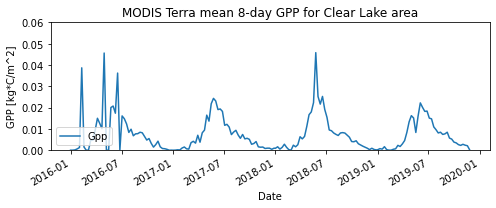

In [26]:
fig, ax = plt.subplots(figsize=(7, 3))

clearlake_gpp_df.plot(ax=ax)

ax.set_xlabel('Date')
ax.set_ylabel('GPP [kg*C/m^2]');
ax.set_title('MODIS Terra mean 8-day GPP for Clear Lake area')

ax.set_ylim((0,0.06))

ax.legend(loc='lower left')

plt.tight_layout()
plt.show()

**Plot timeseries aggregated to monthly means**

In [27]:
# monthly averaging
clearlake_gpp_monthly_df = clearlake_gpp_df.groupby(pd.Grouper(freq="M")).mean()

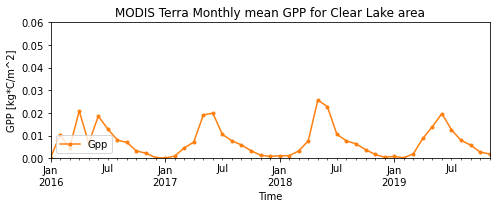

In [28]:
fig, ax = plt.subplots(figsize=(7, 3))

clearlake_gpp_monthly_df.plot(ax=ax, c='tab:orange', marker='.', linestyle='-')

ax.set_xlabel('Time')
ax.set_ylabel('GPP [kg*C/m^2]')
ax.set_title('MODIS Terra Monthly mean GPP for Clear Lake area')

ax.set_ylim((0,0.06))

ax.legend(loc='lower left')

plt.tight_layout()
plt.show()

**Get the mean surface reflectance for this whole *clearlake_aoi*:**

In [30]:
# Surface reflectance time series
clearlake_srb1 = chart.Image.series(**{'imageCollection': scaled_srb1,
                                   'region': clearlake_aoi,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 1000,
                                   'xProperty': 'system:time_start'})

clearlake_srb2 = chart.Image.series(**{'imageCollection': scaled_srb2,
                                   'region': clearlake_aoi,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 1000,
                                   'xProperty': 'system:time_start'})

**Convert to pandas dataframes:**

In [31]:
clearlake_srb1_df = clearlake_srb1.dataframe
clearlake_srb2_df = clearlake_srb2.dataframe

**Plot surface reflectance timeseries**

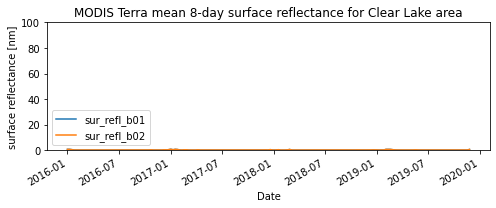

In [35]:
fig, ax = plt.subplots(figsize=(7, 3))

clearlake_srb1_df.plot(ax=ax)
clearlake_srb2_df.plot(ax=ax)

ax.set_xlabel('Date')
ax.set_ylabel('surface reflectance [nm]');
ax.set_title('MODIS Terra mean 8-day surface reflectance for Clear Lake area')

ax.set_ylim((0,100))

ax.legend(loc='lower left')

plt.tight_layout()
plt.show()